In [29]:
#Import Libraries
%reset -f
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

#from scipy.stats import qmc
import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cpu')
print(device)

cpu


In [30]:
data = scipy.io.loadmat('u_sol2_burger.mat')  	# Load data from file
x = data['x']                                   # 200 points between -1 and 1 [256x1]
y = data['t']                                   # 200 time points between 0 and 1 [100x1] 
usol = data['sol']  
X, Y = np.meshgrid(x,y) 

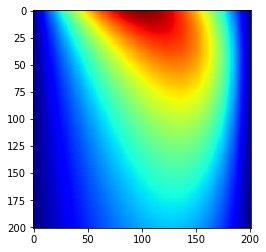

In [31]:
plt.imshow(usol, interpolation='nearest', cmap='jet') 
                #extent=[X.min(), X.max(), Y.min(), Y.max()], 
                #origin='lower', aspect='auto')

In [32]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. -1.]
ub = X_u_test[-1] # [1.  1]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_true = usol.flatten('F')[:,None] 

In [54]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''
    #Topedge condition 1
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    #Bottom edge condition 1
    #bottemedge_x = np.hstack((X[0,:][:,None], Y[-1,:][:,None])) #L1
    #bottemedge_u = usol[-1,:][:,None]

    #Left edge Condition 1
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None])) #L2
    leftedge_u = usol[:,0][:,None]
    
    #Right edge Condition 2
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,0][:,None])) #L4
    rightedge_u = usol[:,-1][:,None]


    all_X_u_train = np.vstack([topedge_x, leftedge_x, rightedge_x]) # X_u_train [200,2] (800 = 200(L1)+200(L2)+200(L3)+200(L4))
    all_u_train = np.vstack([topedge_u, leftedge_u, rightedge_u])   #corresponding u [800x1]

    
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    #sampler = qmc.Sobol(d=2, scramble=False)
    #sample=sampler.random_base2(m=15)
    #X_f_train = qmc.scale(sample, lb, ub) 
    #X_f_train = lb + (ub-lb)*np.random.rand(N_f,2) 
    
    xt1=lb[0] + (ub[0]-lb[0])*np.linspace(0,1,N_f)
    yt1=lb[1] + (ub[1]-lb[1])*np.linspace(0,1,N_f)
    Xt1, Yt1 = np.meshgrid(xt1,yt1)
    X_f_train = np.hstack([Xt1.reshape(N_f*N_f,1),Yt1.reshape(N_f*N_f,1)])

    #X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    return X_f_train, X_u_train, u_train

In [88]:
#neighbour index
def neighbour_index(xx):
    nr = 10
    zn = torch.zeros([xx.shape[0],nr],dtype=torch.int32)
    for j in range(xx.shape[0]): 
        ngr1 = (np.ones([1,nr],dtype='int32')*j)[0].tolist()
        x = xx[j,:][None,:]
        n = x.shape[1]
        ngr1_d= torch.where(torch.linalg.norm(xx-x,axis=1)<0.021)[0].tolist()
        ngr1[0:len(ngr1_d)] = ngr1_d
        zn[j,:] = torch.tensor(ngr1)[0:nr]
    return zn    

In [89]:
#corresponding  inverse matrices 
def inverse_index(X_f_train):
    nr = 10
    zn = torch.zeros([X_f_train.shape[0],nr],dtype=torch.int32)
    zmd = torch.zeros([X_f_train.shape[0],X_f_train.shape[1],X_f_train.shape[1]])
    for j in range(X_f_train.shape[0]): 
            ngr1 = (np.ones([1,nr],dtype='int32')*j)[0].tolist()
            x = X_f_train[j,:][None,:]
            n = x.shape[1]
            md = torch.zeros((n,n)).to(device);
            ngr1_d= torch.where(torch.linalg.norm(X_f_train-x,axis=1)<0.021)[0].tolist()
            ngr1[0:len(ngr1_d)] = ngr1_d
            zn[j,:] = torch.tensor(ngr1)[0:nr]
            xd = X_f_train[ngr1_d[0:nr],:][None,:]-x;
            md = torch.einsum('abi,abj->aij',xd,xd)
            md_inv = torch.inverse(md)
            zmd[j,:,:] = md_inv 
    return zmd

In [90]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
                        
        '''     
        Alternatively:
        
        a = self.activation(self.fc1(a))
        a = self.activation(self.fc2(a))
        a = self.activation(self.fc3(a))
        a = self.fc4(a)
        
        '''
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def grad1(self,xx,n_index,inv_mat):
        zd = torch.zeros(xx.shape)
        m = n_index.shape[1]
        u_0 = self.u_fun(xx)
        x_ngr = xx[n_index.tolist(),:]
        u_ngr = u_0[n_index.tolist(),:]
        x_d  = x_ngr-xx.unsqueeze(1).repeat(1,m,1)
        u_d = u_ngr-u_0.unsqueeze(1).repeat(1,m,1)
        u_ds = torch.sum(torch.einsum('ijp,ikp->ikp',(u_d.permute(0,2,1)),(x_d.permute(0,2,1))),dim=2)
        zd = torch.einsum('kj,kji->ki',u_ds,inv_mat)
        return zd
    
    def grad2(self,xx,u_x_t,n_index,inv_mat):
        zdd = torch.zeros(u_x_t.shape[0], 2*u_x_t.shape[1])
        n = u_x_t.shape[0]
        m = n_index.shape[1]
        x_ngr = xx[n_index.tolist(),:]
        u_xngr = u_x_t[n_index.tolist(),:]
        x_d  = x_ngr-xx.unsqueeze(1).repeat(1,m,1)
        u_xd = u_xngr-u_x_t.unsqueeze(1).repeat(1,m,1)
        u_xds = torch.sum(torch.einsum('ijr,ipr->ijpr',(u_xd.permute(0,2,1)),(x_d.permute(0,2,1))),dim=3)
        zdd = torch.einsum('kij,kjl->kil',u_xds,inv_mat).reshape([n,4])
        return zdd
    
    
    
    def u_fun(self,x):
        x = x.clone()
        return self.forward(x)
    
    def loss_PDE(self, x_to_train_f):
        
        nu = 0.01/np.pi
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        
        u = self.u_fun(x_to_train_f)  
        u_x_y = self.grad1(x_to_train_f,n_index,inv_mat)
        u_xx_yy = self.grad2(x_to_train_f,u_x_y,n_index,inv_mat)                                                    
                                                            
        u_x = u_x_y[:,[0]]
        u_y = u_x_y[:,[1]]
        u_xx = u_xx_yy[:,[0]]
        
        f = u_y + u*u_x -0.1*u_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return  loss_f
    
    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        
        loss_val = 20*loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_u_train, u_train, X_f_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = PINN.test()
        
            print(loss,error_vec)

        return loss        
    
    'test neural network'
    def test(self):
                
        u_pred = self.forward(X_u_test_tensor)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = u_pred.cpu().detach().numpy()
        
        u_pred = np.reshape(u_pred,(201,201),order='F')
        
        u_pred = u_pred.T
                
        return error_vec, u_pred

In [92]:
'Generate Training data'
N_u = 400 #Total number of data points for 'u'
N_f = 51 #Total number of collocation points 
X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f)
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
u_train = torch.from_numpy(u_train_np_array).float().to(device)
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
n_index = neighbour_index(X_f_train)
inv_mat = inverse_index(X_f_train)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)
layers = np.array([2,40,80,40,1]) #8 hidden layers

PINN = Sequentialmodel(layers)

PINN.to(device)

'Neural Network Summary'
print(PINN)

params = list(PINN.parameters())
'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1, 
                              max_iter = 800, 
                              max_eval = None, 
                              tolerance_grad = -1, 
                              tolerance_change = -1, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

start_time = time.time()

optimizer.step(PINN.closure)

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=80, bias=True)
    (2): Linear(in_features=80, out_features=40, bias=True)
    (3): Linear(in_features=40, out_features=1, bias=True)
  )
)
tensor(1.7799, grad_fn=<AddBackward0>) tensor(0.8862, grad_fn=<DivBackward0>)
tensor(1.6492, grad_fn=<AddBackward0>) tensor(0.8230, grad_fn=<DivBackward0>)
tensor(0.9267, grad_fn=<AddBackward0>) tensor(0.8273, grad_fn=<DivBackward0>)
tensor(0.7596, grad_fn=<AddBackward0>) tensor(0.7830, grad_fn=<DivBackward0>)
tensor(0.4783, grad_fn=<AddBackward0>) tensor(0.7605, grad_fn=<DivBackward0>)
tensor(0.3072, grad_fn=<AddBackward0>) tensor(0.7922, grad_fn=<DivBackward0>)
tensor(0.1308, grad_fn=<AddBackward0>) tensor(0.8604, grad_fn=<DivBackward0>)
tensor(0.1197, grad_fn=<AddBackward0>) tensor(0.8563, grad_fn=<DivBackward0>)
tensor(0.0984, grad_fn=<AddBackward0>)

In [101]:
''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))

Test Error: 0.90541


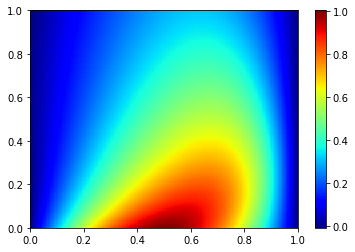

In [102]:
plt.imshow(u_pred, interpolation='nearest', cmap='jet',
                extent=[X.min(), X.max(), Y.min(), Y.max()], 
                origin='lower', aspect='auto')
plt.colorbar()

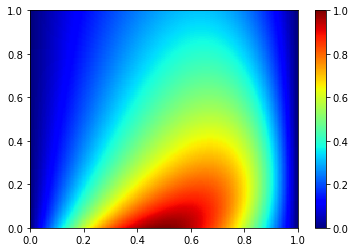

In [103]:
plt.imshow(usol, interpolation='nearest', cmap='jet', 
                extent=[X.min(), X.max(), Y.min(), Y.max()], 
                origin='lower', aspect='auto')
plt.colorbar()

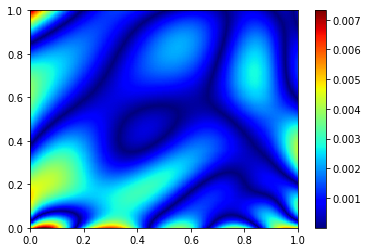

In [104]:
plt.imshow(np.abs(u_pred-usol), interpolation='nearest', cmap='jet',
                extent=[X.min(), X.max(), Y.min(), Y.max()], 
                origin='lower', aspect='auto')
plt.colorbar()